# Boston Marathon Clustering

Data Source: https://github.com/llimllib/bostonmarathon


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, mixture, ensemble
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

In [2]:
# setting styles for plotting# setti 
plt.rcParams['figure.figsize'] = [20, 5]
plt.rc('axes.spines', top=False, right=False)
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('rocket')

In [3]:
df = pd.read_csv('boston_marathon_2014.csv')

In [4]:
df.shape

(31984, 21)

In [5]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [6]:
df.columns

Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k',
       'half', '20k', 'country', 'city', '40k'],
      dtype='object')

In [7]:
# from https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb# from  
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(df).head(10)

Your selected dataframe has 21 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
ctz,30740,96.1
state,2576,8.1
city,1,0.0


In [8]:
#dropping ctz column - 96% missing values
df.drop('ctz', axis=1, inplace=True)

In [9]:
df.dtypes

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object

In [10]:
# some columns that I think should be all numeric are listed as columns
df[pd.to_numeric(df['30k'], errors='coerce').isnull()].head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
2968,42.37,"Koeppe, Torsten",216,106.72,M,49,182.07,3385,2545,-,2700,6.95,MA,-,21.23,89.57,84.90,USA,Andover,171.75
3189,-,"Haushalter, Jeff",647,-,M,47,195.82,3622,4815,160.48,5463,7.48,GA,-,-,-,-,USA,Atlanta,184.62
7272,45.37,"McKinnon, Andrew",1065,114.37,M,48,204.40,8290,6262,-,7616,7.80,NJ,-,22.52,96.03,91.02,USA,Midland Park,191.60
7417,-,"Dennier, Ana C",1650,-,F,42,264.28,8452,9412,218.07,22540,10.08,ON,-,-,-,-,CAN,Toronto,251.72
8211,44.82,"Smith, Lester H.",63,116.15,M,63,209.98,9367,7243,170.18,9341,8.02,NaN,-,22.20,97.37,92.20,AUS,Adelaide,197.90


In [11]:
df = df.replace('-', 0)

In [12]:
df.dtypes

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object

In [13]:
# changing M/F to numeric
df.gender.replace('M', 0, inplace=True)
df.gender.replace('F', 1, inplace=True)

In [14]:
df = df.apply(pd.to_numeric, errors='ignore')

In [15]:
df['gender'] = pd.Categorical(df.gender)
df['country'] = pd.Categorical(df.country)
df['city'] = pd.Categorical(df.city)

In [16]:
df.dtypes

10k           float64
name           object
division        int64
25k           float64
gender       category
age             int64
official      float64
bib            object
genderdiv       int64
35k           float64
overall         int64
pace          float64
state          object
30k           float64
5k            float64
half          float64
20k           float64
country      category
city         category
40k           float64
dtype: object

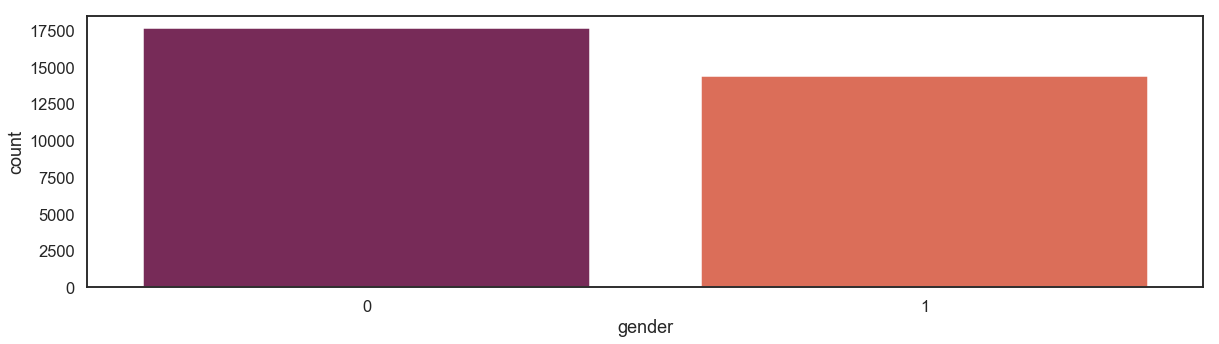

In [17]:
sns.countplot(df.gender, palette='rocket');

In [18]:
#sns.pairplot(df, hue='gender', palette='rocket');

In [19]:
x = df.drop(['name', 'state', 'country','city', 'bib'], axis=1)

In [20]:
normal_X = normalize(x)
standard_X = StandardScaler().fit_transform(x)

#### Normalization: 
Data is rescaled so that 0 <= data <= 1
Why normalize?  
 - Makes training less sensitive to scale of features so we can better solve for coefficients.
 - Improves analysis - makes the data better conditioned for convergence.
 - Ensures convergence problem doesn't have massive variance and makes optimization feasible.
 
#### Standardization
Data is rescaled so that mu = 0 and sigma = 1  

Why standardize?
 - Compare features that have different units/scales.
 
 
https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc

## K-Means - 2 Groups

In [21]:
kmeans = cluster.KMeans(n_clusters=2, random_state=27)
normal_kmeans_labels = kmeans.fit_predict(normal_X)
standard_kmeans_labels = kmeans.fit_predict(standard_X)

In [22]:
pd.crosstab(normal_kmeans_labels, x.gender)

gender,0,1
row_0,,
0,9640,35
1,7977,14332


In [23]:
pd.crosstab(standard_kmeans_labels, x.gender)

gender,0,1
row_0,,
0,12204,8234
1,5413,6133


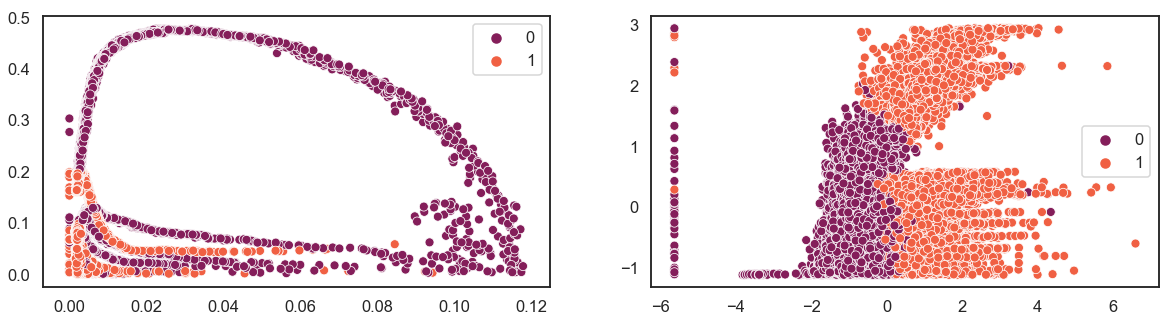

In [24]:
fig, ax = plt.subplots()

plt.subplot(121)
sns.scatterplot(normal_X[:,0], normal_X[:,1], hue=normal_kmeans_labels, palette='rocket')

plt.subplot(122)
sns.scatterplot(standard_X[:,0], standard_X[:,1], hue=standard_kmeans_labels, palette='rocket');

## Mini-Batch K-Means - 2 Groups

In [25]:
minibatch = cluster.MiniBatchKMeans(n_clusters=2, random_state=27)

normal_mini_labels = minibatch.fit_predict(normal_X)
standard_mini_labels = minibatch.fit_predict(standard_X)


pd.crosstab(normal_mini_labels, x.gender)

gender,0,1
row_0,,
0,0,14335
1,17617,32


In [26]:
pd.crosstab(standard_mini_labels, x.gender)

gender,0,1
row_0,,
0,6887,8131
1,10730,6236


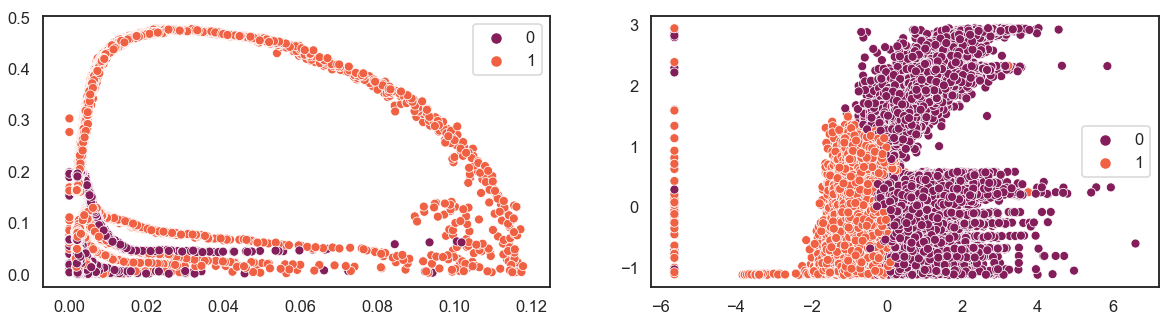

In [27]:
fig, ax = plt.subplots()

plt.subplot(121)
sns.scatterplot(normal_X[:,0], normal_X[:,1], hue=normal_mini_labels, palette='rocket')

plt.subplot(122)
sns.scatterplot(standard_X[:,0], standard_X[:,1], hue=standard_mini_labels, palette='rocket');

In [28]:
from sklearn.metrics import silhouette_samples, silhouette_score

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_score(normal_X, normal_mini_labels, metric='euclidean',sample_size=5000)


0.4007408119811084

In [29]:
y= normal_mini_labels

In [30]:
# train random forest - use cross val scores to make sure this is a good model
rfr = ensemble.RandomForestRegressor(random_state=27)
rfr.fit(normal_X, y)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, rfr.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=False).head(10)
importances

,Gini-importance
overall,0.998371
gender,0.000516
35k,0.000457
25k,0.000333
pace,0.000142
40k,0.000094
30k,0.000087
10k,0.000000
division,0.000000
age,0.000000


In [31]:
minibatch_=dict()
for i in range(1, 10):
    minibatch_[i] = cluster.MiniBatchKMeans(n_clusters=i, random_state=27)
    normal_mini_labels = minibatch.fit_predict(normal_X)
minibatch_


{1: MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
         init_size=None, max_iter=100, max_no_improvement=10, n_clusters=1,
         n_init=3, random_state=27, reassignment_ratio=0.01, tol=0.0,
         verbose=0),
 2: MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
         init_size=None, max_iter=100, max_no_improvement=10, n_clusters=2,
         n_init=3, random_state=27, reassignment_ratio=0.01, tol=0.0,
         verbose=0),
 3: MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
         init_size=None, max_iter=100, max_no_improvement=10, n_clusters=3,
         n_init=3, random_state=27, reassignment_ratio=0.01, tol=0.0,
         verbose=0),
 4: MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
         init_size=None, max_iter=100, max_no_improvement=10, n_clusters=4,
         n_init=3, random_state=27, reassignment_ratio=0.01, tol=0.0,
         verbose=0),
 5: MiniBatchKMeans(batch_size=1

(array([4.4000e+01, 1.1660e+03, 1.0665e+04, 1.0657e+04, 5.5830e+03,
        2.7370e+03, 9.2600e+02, 1.9400e+02, 1.0000e+01, 2.0000e+00]),
 array([ 80.6  , 126.428, 172.256, 218.084, 263.912, 309.74 , 355.568,
        401.396, 447.224, 493.052, 538.88 ]),
 <a list of 10 Patch objects>)

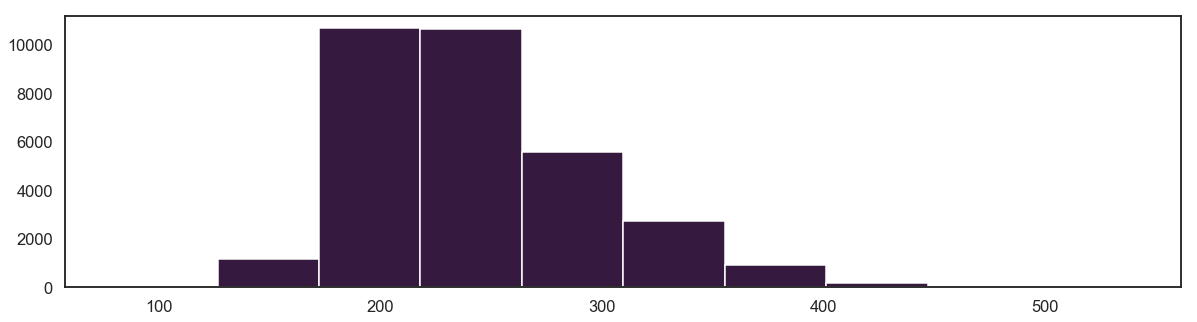

In [32]:
plt.hist(df.official)

In [33]:
def edges(s, n, rnd=2, sig_mult=1):
    mu = s.mean()
    sig = s.std()
    mn = s.min()
    mx = s.max()

    sig = np.arange(-n // 2, (n + 1) // 2 + 1) * sig * sig_mult
    ms = (mu + sig)

    # Checking if mins and maxs are in range of sigs
    if mn < ms.min():
        ms = np.concatenate([[mn], ms])
    if mx > max(ms):
        ms = np.concatenate([ms, [mx]])

    return ms.round(rnd).tolist()

In [34]:
official_bins = edges(s=df.official, n=8)
official_bins

[33.8, 86.1, 138.4, 190.7, 243.0, 295.3, 347.6, 399.9, 452.2, 538.88]

In [35]:
bin_df = df.copy()
bin_df['binned_official'] = pd.cut(df['official'], official_bins)

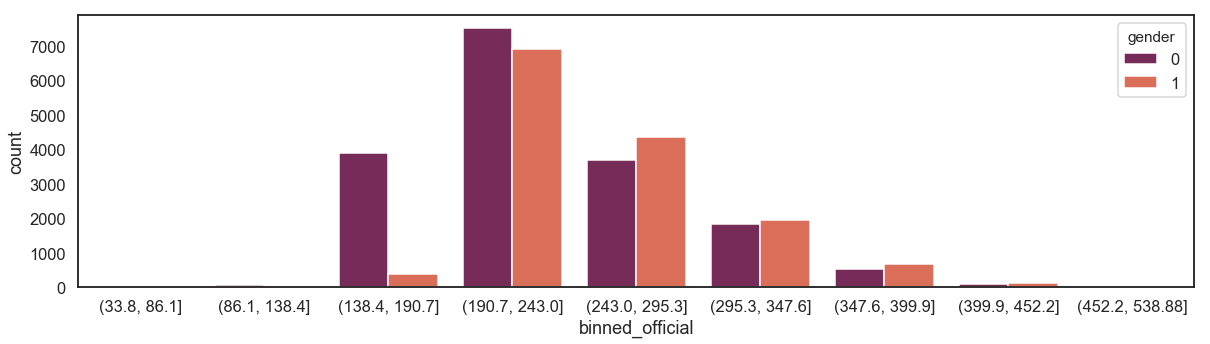

In [36]:
sns.countplot(bin_df.binned_official, hue=bin_df.gender, palette='rocket');

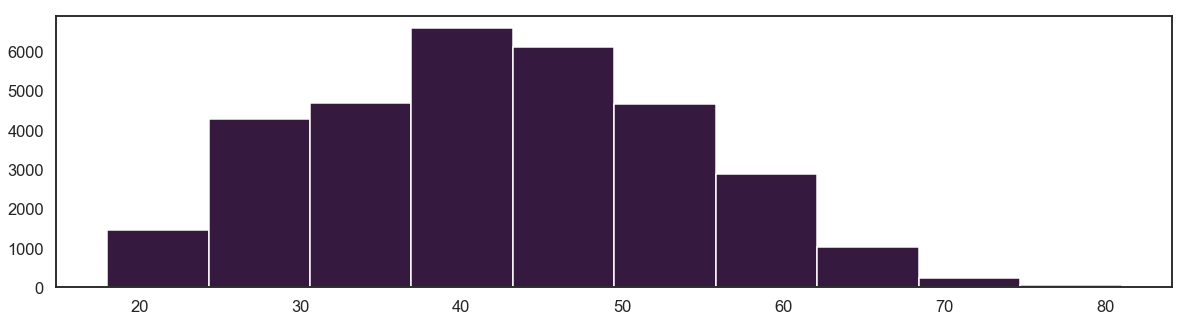

In [37]:
plt.hist(df.age);

In [38]:
# binning ages
bins = [10, 20, 30, 40, 50, 60, 70, 80]
bin_df['binned_age'] = pd.cut(df['age'], bins)

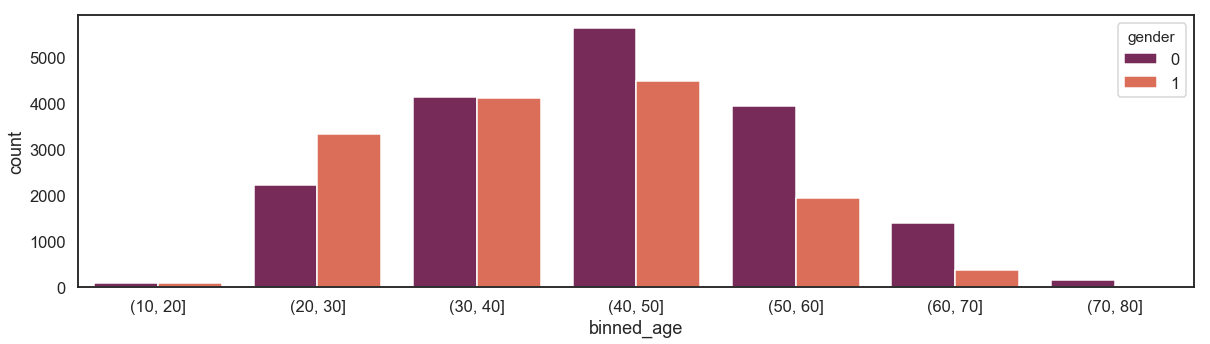

In [39]:
sns.countplot(bin_df.binned_age, hue=bin_df.gender, palette='rocket');

In [40]:
x = df.drop(['name', 'state', 'country','city', 'bib'], axis=1)

In [41]:
# have to one hot encode binned_age =  categorical variable
x = pd.get_dummies(x)
x.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,gender_0,gender_1
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,1,0
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,0,1
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,1,0
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,0,1
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,1,0


In [59]:
X = normalize(x)

### K-Means - 6 Groups

In [60]:
kmeans = cluster.KMeans(n_clusters=6, random_state=27)
labels = kmeans.fit_predict(X)

In [61]:
pd.crosstab(labels, bin_df.binned_age)

binned_age,"(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]"
row_0,,,,,,,
0,3639,2747,2167,78,1812,377,13
1,2644,1655,868,48,2642,1300,160
2,0,1935,1148,38,0,0,0
3,41,126,181,4,7,0,0
4,2954,440,58,6,1303,91,2
5,845,1367,1135,11,134,2,0


In [62]:
pd.crosstab(labels, bin_df.binned_official)

binned_official,"(33.8, 86.1]","(86.1, 138.4]","(138.4, 190.7]","(190.7, 243.0]","(243.0, 295.3]","(295.3, 347.6]","(347.6, 399.9]","(399.9, 452.2]","(452.2, 538.88]"
row_0,,,,,,,,,
0,0,0,0,3752,1932,671,4355,122,2
1,0,0,0,3170,1839,526,3691,90,6
2,0,2189,0,932,0,0,0,0,0
3,9,290,59,1,0,0,0,0,0
4,0,1444,0,3410,0,0,0,0,0
5,0,350,0,3144,0,0,0,0,0


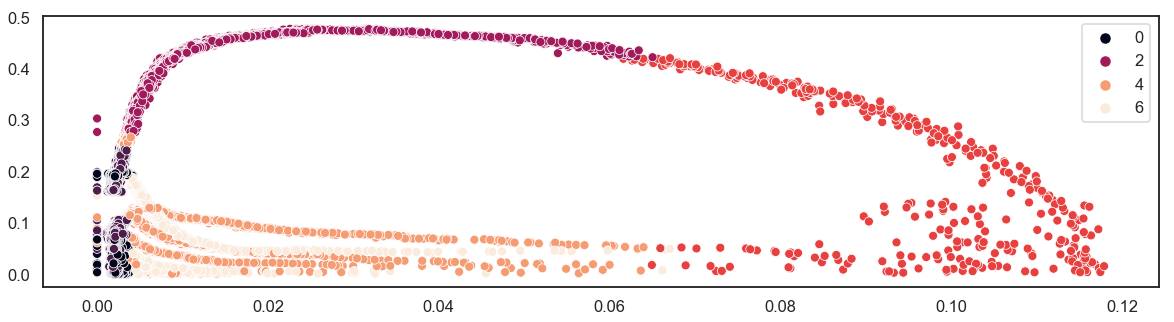

In [63]:
sns.scatterplot(X[:,0], X[:,1], hue=labels, palette='rocket');

### Determining K using the Elbow Method

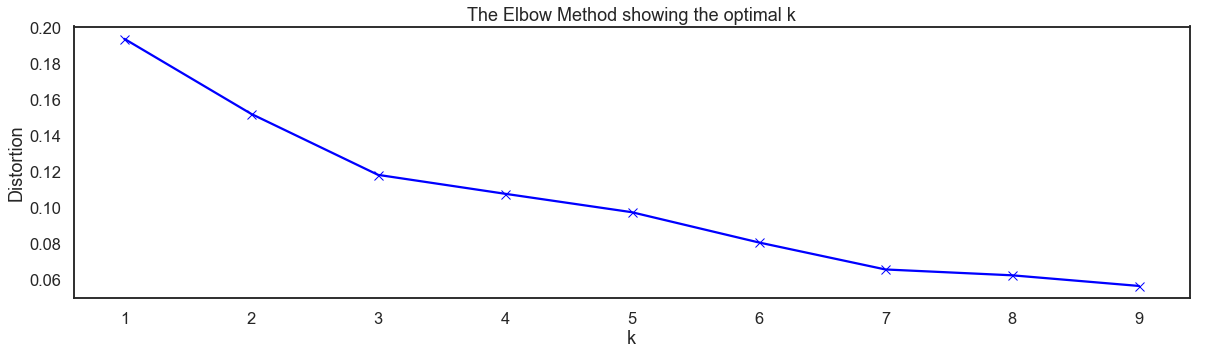

In [68]:
# determine k using elbow method

from sklearn import metrics
from scipy.spatial.distance import cdist

# create new plot and data
plt.plot()
X = X
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### From the graph above it looks like the optimal value for K is 3.

In [69]:
# rerunning kmeans with k=3
kmeans = cluster.KMeans(n_clusters=3, random_state=27)
labels = kmeans.fit_predict(X)

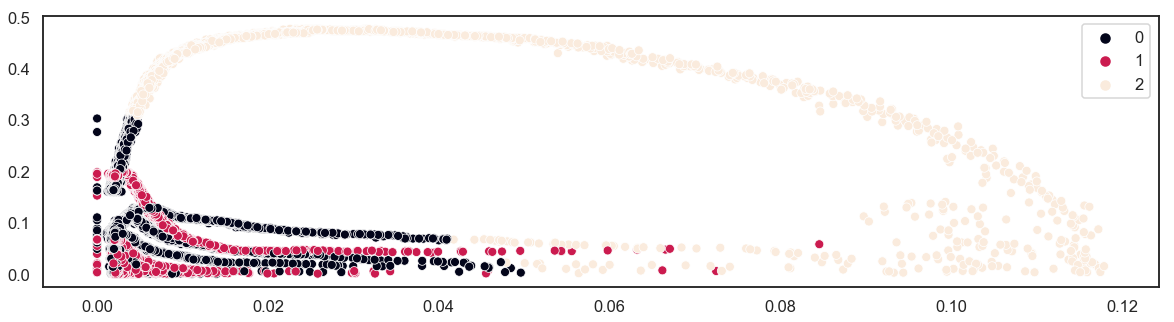

In [93]:
sns.scatterplot(X[:,0], X[:,1], hue=labels, palette='rocket');

In [72]:
# finding important features for 3 clusters
rfr = ensemble.RandomForestRegressor(random_state=27)
rfr.fit(X, y)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, rfr.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=False).head(10)
importances

,Gini-importance
genderdiv,0.701244
division,0.194460
overall,0.040936
official,0.028367
gender_0,0.026265
pace,0.003010
gender_1,0.001997
40k,0.001278
5k,0.000713
age,0.000563


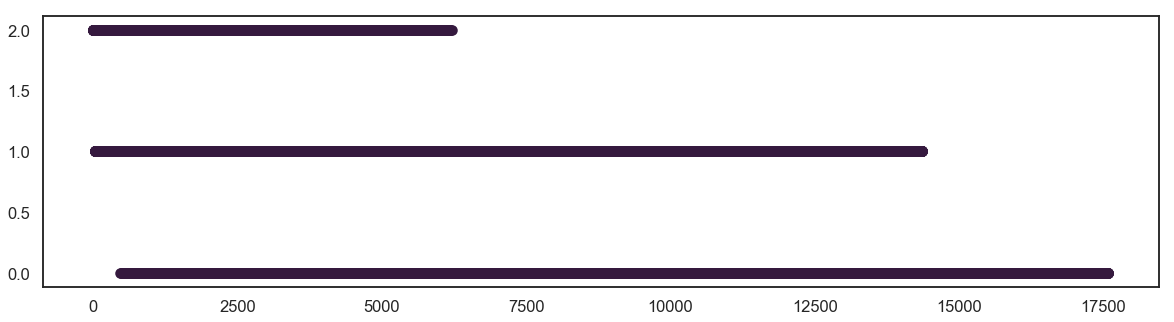

In [76]:
# plotting to see if we have clean clusters
plt.scatter(x.genderdiv, labels);

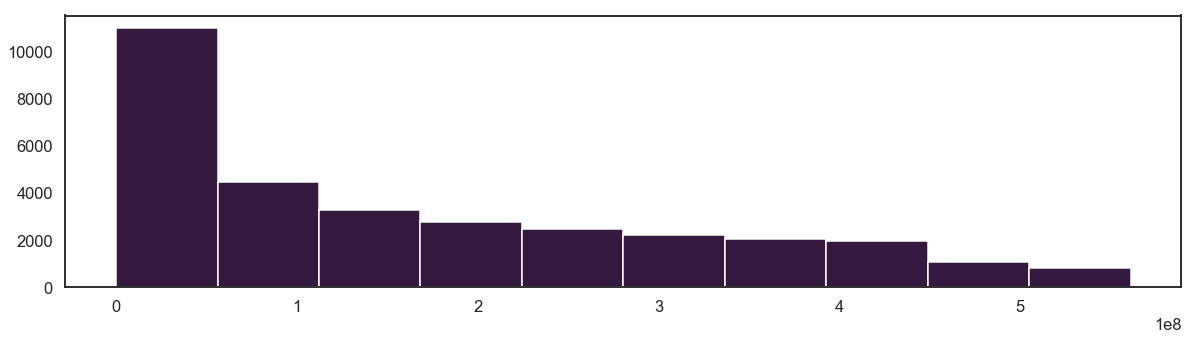

In [91]:
# let's see what happends if we combine some of the more important features
df['gender_overall'] = df['genderdiv'] * df['overall']
plt.hist(df.gender_overall)
plt.show();

gender_overall_bins = edges(s=df.gender_overall, n=9)

bin_df['binned_gender_overall'] = pd.cut(df['gender_overall'], gender_overall_bins)

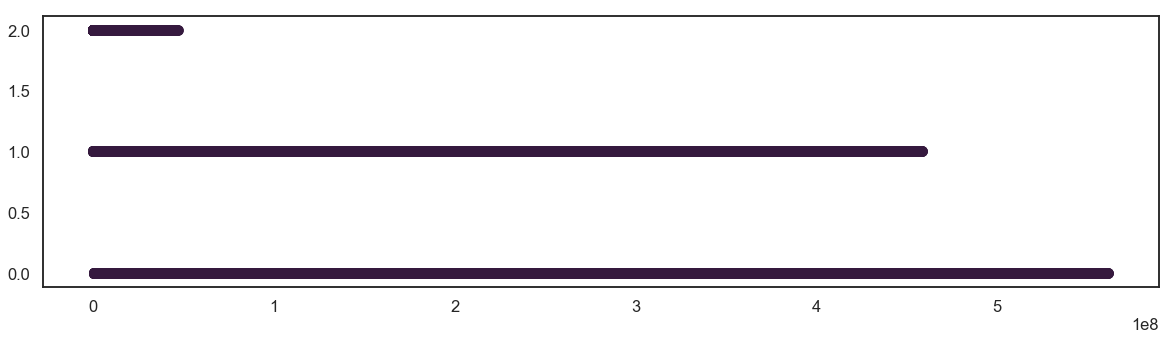

binned_gender_overall,"(-140219863.49, 14008777.57]","(14008777.57, 168237418.62]","(168237418.62, 322466059.68]","(322466059.68, 476694700.74]","(476694700.74, 630923341.8]"
row_0,,,,,
0,1203,5963,2682,1252,3277
1,1649,6571,2497,0,3613
2,2464,813,0,0,0


In [97]:
#it still looks like the bins aren't super clean
plt.scatter(df['gender_overall'], labels)
plt.show();

pd.crosstab(labels, bin_df['binned_gender_overall'])

#### Let's see if we can get clean clusters by using PCA.

In [101]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])
principalDf.head()

,pc1,pc2,pc3
0,-17946.693439,227.270271,381.576309
1,-17937.730824,238.896574,390.368951
2,-17956.703645,229.816828,388.006345
3,-17931.299977,239.892462,388.965309
4,-17955.272151,229.458707,387.076775


In [102]:
# rerunning kmeans with k=3
kmeans = cluster.KMeans(n_clusters=3, random_state=27)
pca_labels = kmeans.fit_predict(principalDf)

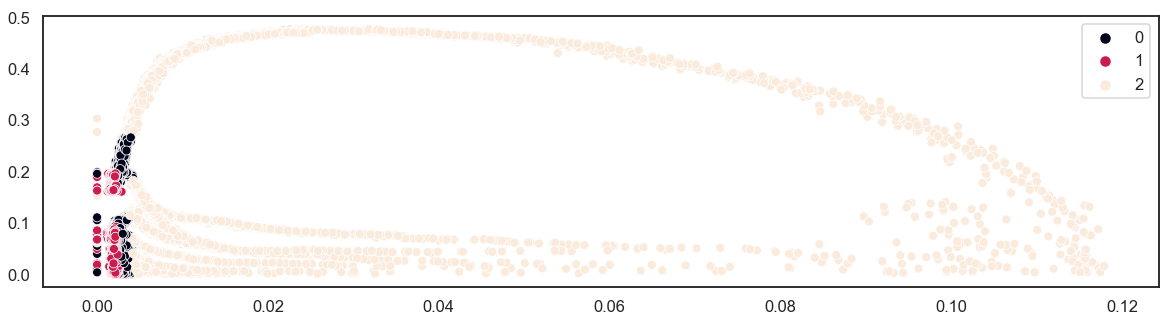

pc1,-17956.703645132944,-17955.838695689843,-17955.272150672663,-17954.409267985884,-17953.852559759074,-17952.988728579552,-17952.385237507322,-17951.559729301473,-17950.965691790578,-17950.143494912794,...,18744.28506841485,18748.87445086249,18770.79584450879,18775.72954110187,18782.36990686179,18785.04077224758,18791.81081683701,18799.799443325814,18800.710331688057,18826.103456548524
row_0,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [107]:
sns.scatterplot(X[:,0], X[:,1], hue=pca_labels, palette='rocket')
plt.show();

pd.crosstab(pca_labels, principalDf.pc1)

### Mini-Batch K-Means - 6 Groups

In [47]:
minibatch = cluster.MiniBatchKMeans(n_clusters=6, random_state=27, batch_size=50, n_init=5)


# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatch.fit_predict(X)


pd.crosstab(predict_mini, bin_df.binned_age)

binned_age,"(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]"
row_0,,,,,,,
0,0,3393,2755,116,0,0,0
1,3806,422,0,0,1863,378,13
2,49,161,224,4,9,0,0
3,678,1620,1346,19,83,1,0
4,0,1985,1149,42,0,0,0
5,5590,689,83,4,3943,1391,162


In [48]:
pd.crosstab(predict_mini, bin_df.binned_official)

binned_official,"(33.8, 86.1]","(86.1, 138.4]","(138.4, 190.7]","(190.7, 243.0]","(243.0, 295.3]","(295.3, 347.6]","(347.6, 399.9]","(399.9, 452.2]","(452.2, 538.88]"
row_0,,,,,,,,,
0,0,0,0,1461,1613,483,2629,76,2
1,0,0,0,2409,952,339,2716,66,1
2,9,378,59,1,0,0,0,0,0
3,0,350,0,3397,0,0,0,0,0
4,0,2113,0,1063,0,0,0,0,0
5,0,1432,0,6078,1206,375,2701,70,5


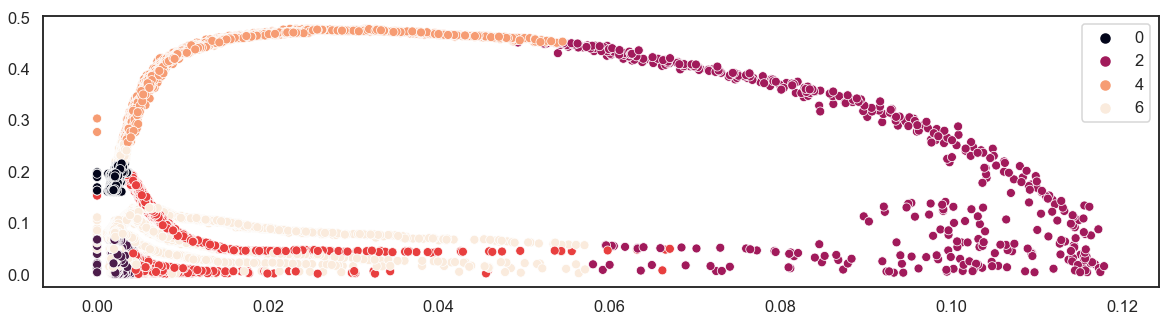

In [49]:
sns.scatterplot(X[:,0], X[:,1], hue=predict_mini, palette='rocket');

In [50]:
y=predict_mini
# train random forest - use cross val scores to make sure this is a good model
rfr = ensemble.RandomForestRegressor(random_state=27)
rfr.fit(X, y)

rfr_scores = cross_val_score(rfr, X, y, cv=5)
rfr_scores

array([0.86161127, 0.99980694, 0.99548879, 0.99993302, 0.99901451])

In [51]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, rfr.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=False).head(10)
importances

,Gini-importance
genderdiv,0.701244
division,0.194460
overall,0.040936
official,0.028367
gender_0,0.026265
pace,0.003010
gender_1,0.001997
40k,0.001278
5k,0.000713
age,0.000563


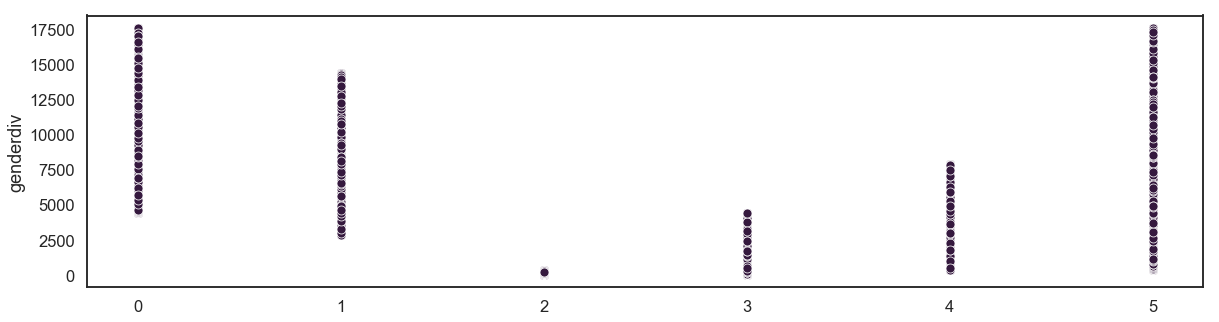

In [52]:
sns.scatterplot(y=df.genderdiv, x=predict_mini);

In [53]:
genderdiv_bins = edges(s=df.genderdiv, n=15)
genderdiv_bins

[-29981.0,
 -25226.99,
 -20472.99,
 -15718.98,
 -10964.98,
 -6210.97,
 -1456.97,
 3297.04,
 8051.04,
 12805.05,
 17559.06,
 22313.06,
 27067.07,
 31821.07,
 36575.08,
 41329.08,
 46083.09]

In [54]:
bin_df['binned_genderdiv'] = pd.cut(df['genderdiv'], genderdiv_bins)
bin_df.sample(10)

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,...,30k,5k,half,20k,country,city,40k,binned_official,binned_age,binned_genderdiv
27320,58.22,"Ansin, Kristopher",5284,145.07,0,29,307.60,30776,15664,228.65,...,177.43,29.30,121.78,115.65,USA,Cambridge,288.78,"(295.3, 347.6]","(20, 30]","(12805.05, 17559.06]"
19798,54.10,"Reider, Jeffrey",900,152.82,0,61,299.87,22608,15350,236.82,...,193.35,26.15,124.42,117.22,USA,Bloomfield Hills,281.00,"(295.3, 347.6]","(60, 70]","(12805.05, 17559.06]"
28821,59.53,"Luo, Lana",5366,157.78,1,28,286.48,32389,11092,232.37,...,193.97,29.70,129.40,122.48,USA,Medford,271.03,"(243.0, 295.3]","(20, 30]","(8051.04, 12805.05]"
2129,43.42,"Soutiea, Gregory",2400,110.72,0,30,190.35,2423,3848,157.00,...,133.52,21.58,93.22,88.23,USA,Brighton,180.43,"(138.4, 190.7]","(20, 30]","(3297.04, 8051.04]"
15209,49.95,"Cormier, Melissa A.",3090,127.43,1,35,227.02,17388,4864,185.12,...,155.38,25.22,106.47,100.90,USA,Freeport,214.52,"(190.7, 243.0]","(30, 40]","(3297.04, 8051.04]"
9431,46.42,"Geissinger, John D",391,116.35,0,51,197.38,10804,5045,163.97,...,140.22,23.22,97.98,92.88,USA,Austin,187.37,"(190.7, 243.0]","(50, 60]","(3297.04, 8051.04]"
14590,49.75,"Eaton, Darcy G.",885,129.15,1,45,234.82,16688,6117,191.27,...,159.62,24.78,107.48,101.55,USA,Carlsbad,222.42,"(190.7, 243.0]","(40, 50]","(3297.04, 8051.04]"
8560,43.48,"Kallerud, Royce R",232,106.30,0,45,182.63,9770,2645,149.83,...,127.87,21.95,90.07,85.57,USA,Kirksville,171.95,"(138.4, 190.7]","(40, 50]","(-1456.97, 3297.04]"
28983,54.60,"Kennedy, Katherine C.",4118,137.68,1,36,246.83,32563,7716,199.60,...,166.57,28.03,115.52,109.62,USA,Boston,231.97,"(243.0, 295.3]","(30, 40]","(3297.04, 8051.04]"
20503,66.37,"Bigelow, Harland E",415,175.25,0,67,305.62,23402,15577,249.27,...,209.20,31.52,143.98,135.73,USA,Lisle,285.77,"(295.3, 347.6]","(60, 70]","(12805.05, 17559.06]"


In [55]:
pd.crosstab(predict_mini, bin_df.binned_genderdiv)

binned_genderdiv,"(-1456.97, 3297.04]","(3297.04, 8051.04]","(8051.04, 12805.05]","(12805.05, 17559.06]","(17559.06, 22313.06]"
row_0,,,,,
0,0,1361,2649,2251,3
1,80,2835,2787,781,0
2,447,0,0,0,0
3,3189,558,0,0,0
4,1864,1312,0,0,0
5,1067,3442,4072,3273,13


### DBSCAN

In [ ]:
dbscan = cluster.DBSCAN(eps= 0.042, min_samples=5, metric='minkowski',algorithm='ball_tree', leaf_size=90, p=2)
predict_DB = dbscan.fit(X)

db_labels = predict_DB.labels_

In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in labels else 0)
n_clusters_

In [ ]:
pd.crosstab(db_labels, bin_df.binned_age)

In [ ]:
pd.crosstab(db_labels, bin_df.binned_official)

In [ ]:
sns.scatterplot(X[:,0], X[:,1], hue=labels, palette='rocket');

In [ ]:
y=db_labels
# train random forest - use cross val scores to make sure this is a good model
rfr = ensemble.RandomForestRegressor(random_state=27)
rfr.fit(X, y)

rfr_scores = cross_val_score(rfr, X, y, cv=5)
rfr_scores

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, rfr.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=False).head(10)
importances

In [ ]:
sns.scatterplot(x=db_labels, y=df.division)

In [ ]:
len(db_labels)

### Gaussian Mixture

In [ ]:
g_mix = mixture.GaussianMixture(n_components=6, random_state=27)
g_mix = g_mix.fit(X).predict(X)

#means = g_mix.means_
pd.crosstab(g_mix, bin_df.binned_age)

In [ ]:
pd.crosstab(g_mix, bin_df.binned_official)

In [ ]:
sns.scatterplot(X[:,0], X[:,1], hue=g_mix, palette='rocket');

### Mean Shift

In [ ]:
mean_shift = cluster.MeanShift(bin_seeding=True)
mean_shift = mean_shift.fit(X)

ms_labels = mean_shift.labels_

In [ ]:
n_clusters = len(np.unique(labels))

print ('Number of estimated Clusters: {}'.format(n_clusters))

pd.crosstab(ms_labels, bin_df.binned_age)

In [ ]:
pd.crosstab(ms_labels, bin_df.binned_official)

In [ ]:
sns.scatterplot(X[:,0], X[:,1], hue=ms_labels, palette='rocket')

## Evaluation of Features  
By training a classifier on the cluster labels we can find which features are most relevant!

In [ ]:
# set our labels to equal y
y=labels

In [ ]:
# train random forest - use cross val scores to make sure this is a good model
rfr = ensemble.RandomForestRegressor(random_state=27)
rfr.fit(X, y)

rfr_scores = cross_val_score(rfr, X, y, cv=5)
rfr_scores

In [ ]:
##  mean score and the 95% confidence interval of the score estimate
print("Accuracy: %0.2f (+/- %0.2f)" % (rfr_scores.mean(), rfr_scores.std() * 2))

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, rfr.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=False).head(10)
importances

In [ ]:
# it looks like division is our most important feature - lets make bins of divisions and compare to our clusters
division_bins = edges(df.official)
division_bins

In [ ]:
bin_df['binned_division'] = pd.cut(df['division'], division_bins)

In [ ]:
sns.countplot(bin_df.binned_division, hue=bin_df.gender, palette='rocket');

In [ ]:
pd.crosstab(ms_labels, bin_df.binned_division)

In [ ]:
# have to one hot encode binned_division =  categorical variable
x = pd.get_dummies(df)
x.head()